In [1]:
from htc_class_testing import HolsteinTavisCummings
import numpy as np
from qutip import *
from qutip.core.gates import *
from numpy import array
from numpy import real
import matplotlib.pyplot as plt
pi = np.pi
hf_params = {
    'w_q1': 0.8365513706206968,         # Qubit 1 frequency (e.g., in GHz)
    'w_q2': 0.8365513706206968,         # Qubit 2 frequency
    'w_vib1': 0.018335911729858174,       # Vibrational mode 1 frequency
    'w_vib2': 0.018335911729858174,      # Vibrational mode 2 frequency
    'w_cav': 5 * np.pi,        # Cavity frequency
    'S_1': 1.0,         # Huang-Rhys factor for qubit 1 and vib 1
    'S_2': 1.0,         # Huang-Rhys factor for qubit 2 and vib 2
    'lambda_1': 0.026919208248238624,     # Cavity coupling strength for qubit 1
    'lambda_2': 0.026919208248238624,    # Cavity coupling strength for qubit 2
    'N_vib': 2,         # Number of vibrational states to include
    'N_cav': 2,          # Cavity truncation level
    'qubit_1_dipole_moments' : 
    { 
        'mu_g': -0.7275466054308762, #ground dipole moment
        'mu_e': 0.7751862316027126, #excited dipole moment
        'mu_eg': 0.8142093557243336 #transition dipole moment
    },
    'qubit_2_dipole_moments' : 
    { 
        'mu_g': -0.7275466054308762, #ground dipole moment
        'mu_e': 0.7751862316027126, #excited dipole moment
        'mu_eg': 0.8142093557243336 #transition dipole moment
    }
}

# using the same paramters as the tutorial for now!
tutorial_params = {

    'w_q1': 3 * 2 * np.pi,         # Qubit 1 frequency (e.g., in GHz)
    'w_q2': 2 * 2 * np.pi,         # Qubit 2 frequency
    'w_vib1': 0.2, #18335911729858174,       # Vibrational mode 1 frequency
    'w_vib2': 0.2, #18335911729858174,      # Vibrational mode 2 frequency
    'w_cav': 5 * 2 * np.pi,        # Cavity frequency
    'S_1': 0.19,         # Huang-Rhys factor for qubit 1 and vib 1
    'S_2': 0.19,         # Huang-Rhys factor for qubit 2 and vib 2
    'lambda_1': 0.0,     # Cavity coupling strength for qubit 1
    'lambda_2': 0.0,    # Cavity coupling strength for qubit 2
    'N_vib': 2,         # Number of vibrational states to include
    'N_cav': 2,          # Cavity truncation level
    'simple_g' : True,
    'sigma_z_Hq' : True, # formulate qubit Hamiltonians as -w / 2 * sigma_z
    'g1' : 0.01 * 2 * np.pi,
    'g2' : 0.0125 * 2 * np.pi
}


# Example parameters
system = HolsteinTavisCummings( tutorial_params )
g1 = system.g1
g2 = system.g2


tlist = np.linspace(0, 200, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2 *pi)/(4 * g2)


In [2]:
system.build_hamiltonian()
#g1 = system._g1
#g2 = system._g2

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2 *pi)/(4 * g2)

# the following attributes store the different contributions to the Hamiltonian (all on the full Hilbert space)
### Bare Hamiltonians
# .H_q1 -> qubit 1 Hamiltonian
# .H_q2 -> qubit 2 Hamiltonian
# .H_qubit -> qubit 1 + qubit 2 Hamiltonian 
# .H_vib1 -> vibrational Hamiltonian for qubit 1
# .H_vib2 -> vibrational Hamiltonian for qubit 2
# .H_vibrational -> vibrational Hamiltonians for qubit 1 + qubit 2
# .H_cav -> cavity Hamiltonian

# Coupling Hamiltonians
# Note on qubit - cavity coupling - several flavors available:
#  a. Tavis-Cummings (parameterized by `g1` and `g2` or by `sqrt(w1/2) * lambda * mu1_{eg}` and  `sqrt(w2/2) * lambda * mu2_{eg}`  
#  b. Pauli-Fierz (sqrt(w1/2) * lambda * mu1, sqrt(w2/2) * lambda * mu2 using full operators)
#  c. If Pauli-Fierz, may also include dipole self energy if requested

# .H_q1_cav -> coupling between qubit 1 and cavity
# .H_q2_cav -> coupling between qubit 2 and cavity
# .H_qubit_cavity_coupling -> coupling between qubits 1 and 2 and cavity

# .H_q1_vib1 -> vibronic coupling for qubit 1
# .H_q2_vib2 -> vibronic coupling for qubit 2
# .H_qubit_vibrational_coupling -> vibronic couplings for qubit 1 and qubit 2

Using Tavis-Cummings coupling
Using simple g coupling
g1: 0.06283185307179587, g2: 0.07853981633974483


In [3]:
wc = system.w_cav
w1 = system.w_q1
w2 = system.w_q2
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)
    #return w1 + (w2 - w1) * (0 > np.sin(t * pi/t0))

def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)
    #return step_t(w1,wc,T_gate_1,width,t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)
    #return step_t(w2,wc,T_gate_2,width,t)

def time_dependent_polaron_basis(t, args=None):
    return system.build_polaron_basis_t(t, T0_1, T_gate_1, T0_2, T_gate_2)

In [4]:
# Hamiltonian using QuTiP
# Hc = a.dag() * a
# H1 = - 0.5 * sz1
# H2 = - 0.5 * sz2
# Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
# Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())
Hc = system.number_cavity
H1 = -0.5 * system.sigmaz_1
H2 = -0.5 * system.sigmaz_2


In [5]:
# Qutip code looked like the following:
# H_t = [[H1, w1_t], [H2, w2_t], [Hc, wc_t], Hc1+Hc2]

# we will adapt to our class as follows:
#H_t = [[system.H_cav, wc_t], [system.H_q1, w1_t], [system.H_q2, w2_t], system.H_qubit_cavity_coupling]
if system.N_vib > 1:
    H_t = [[H1, w1_t], [H2, w2_t], [Hc, wc_t], system.H_qubit_cavity_coupling + system.H_vibrational + system.H_qubit_vibrational_coupling]
else:
    H_t = [[H1, w1_t], [H2, w2_t], [Hc, wc_t], system.H_qubit_cavity_coupling]
H_t[0]

[Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=CSR, isherm=True
 Qobj data =
 [[-0.5  0.   0.  ...  0.   0.   0. ]
  [ 0.  -0.5  0.  ...  0.   0.   0. ]
  [ 0.   0.  -0.5 ...  0.   0.   0. ]
  ...
  [ 0.   0.   0.  ...  0.5  0.   0. ]
  [ 0.   0.   0.  ...  0.   0.5  0. ]
  [ 0.   0.   0.  ...  0.   0.   0.5]],
 <function __main__.w1_t(t, args=None)>]

$H(t) = (w1 + \text{pulse for qubit 1}) \cdot (-0.5 \cdot sz1) + (w2 + \text{pulse for qubit 2}) \cdot (-0.5 \cdot sz2) + wc \cdot (a^{\dagger} a) + g1 (a^{\dagger} sm1 + a sm1^{\dagger}) + g2 (a^{\dagger} sm2 + a sm2^{\dagger})$

In [6]:
H_t = [time_dependent_polaron_basis]

In [7]:
# initial state: start with one of the qubits in its excited state - note we need to reorder basis
# the qutip had cavity basis first, we have it last 
# qutip tutorial: psi0 = tensor(basis(N,0),basis(2,1),basis(2,0)) 
# equivalent in our basis: psi0 = tensor(basis(2,1), basis(2,0), basis(N,0))
psi0 = tensor(basis(2,1), basis(2,0),basis(2,0),basis(2,0), basis(system.N_cav,0))
#psi0 = system.H_vecs * psi

In [8]:
res = mesolve(H_t, psi0, tlist, [], e_ops=[])

In [9]:
res.states

[Quantum object: dims=[[2, 2, 2, 2, 2], [1]], shape=(32, 1), type='ket', dtype=Dense
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [1.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]
  [0.]],
 Quantum object: dims=[[2, 2, 2, 2, 2], [1]], shape=(32, 1), type='ket', dtype=Dense
 Qobj data =
 [[ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 2.73725141e-07-1.13721174e-06j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  

In [10]:
# these operators need to be defined for the plot below

# cavity operators on the full Hilbert space
a = tensor( qeye(2), qeye(2), qeye(2), qeye(2), destroy(system.N_cav) )
n = a.dag() * a

# operators for qubit 1
sm1 = tensor( destroy(2), qeye(2), qeye(2), qeye(2), qeye(system.N_cav) ) 
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = sm1 = tensor(qeye(2) , destroy(2), qeye(2),qeye(2), qeye(system.N_cav) ) 
sz2 = tensor(qeye(2), sigmaz(), qeye(2),qeye(2), qeye(system.N_cav) )
n2 = sm2.dag() * sm2

In [11]:
tlist[-1]

np.float64(200.0)

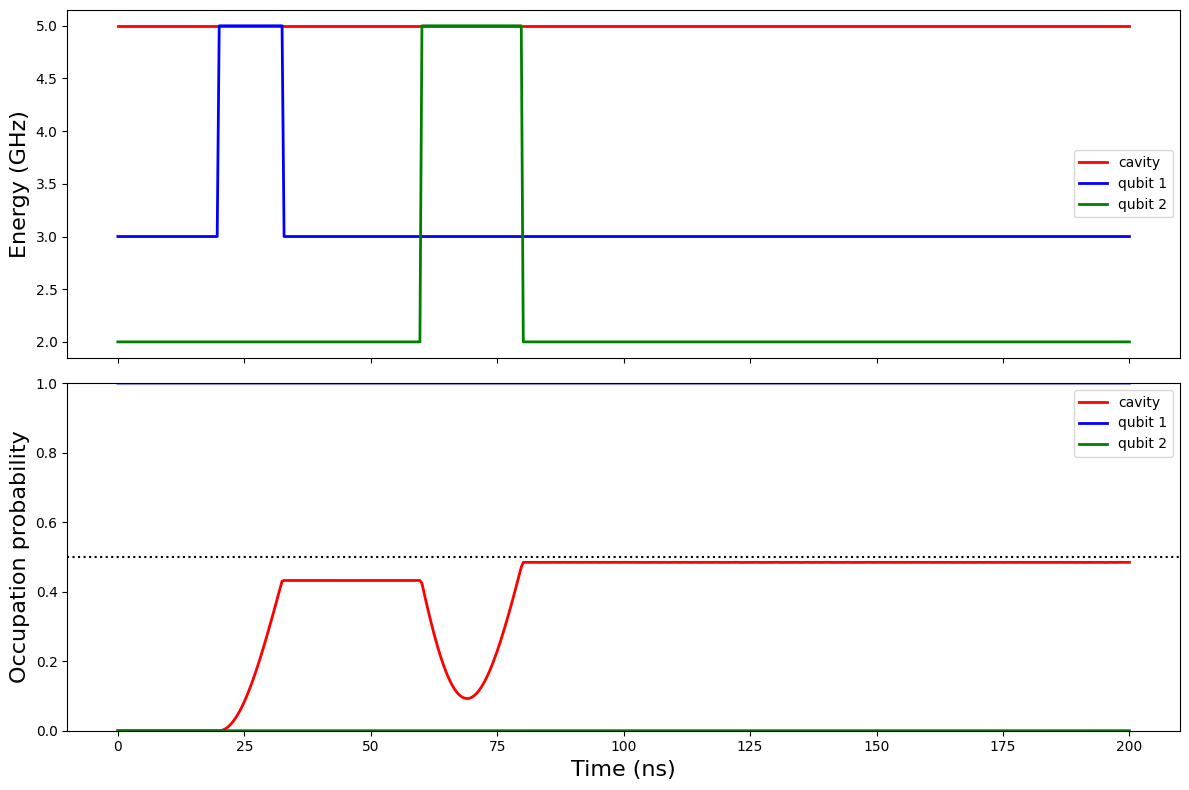

In [12]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
#axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].axhline(y=0.5, xmin=0, xmax=tlist[-1],c='k',linestyle=':') #center line, in ideal iSWAP gate both qubits occupational probabilities at 0.5
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

In [13]:
rho_final = res.states[-1]
rho_final

Quantum object: dims=[[2, 2, 2, 2, 2], [1]], shape=(32, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j]
 [ 5.45990465e-06+1.32606864e-06j]
 [ 1.07910530e-03+6.58004978e-04j]
 [-1.81105655e-06+2.95154687e-07j]
 [ 2.94336912e-03+1.37108386e-03j]
 [ 1.64654305e-04+1.55692412e-05j]
 [ 8.07188581e-04+8.01793419e-04j]
 [-1.05533294e-04-1.24744019e-04j]
 [ 2.20809064e-03+1.21819868e-03j]
 [ 6.30313025e-05-5.94172328e-05j]
 [ 6.19706399e-04-7.38237482e-05j]
 [ 2.67530418e-05-3.58004651e-05j]
 [-1.05720226e-05+1.63881329e-05j]
 [-6.64055022e-01-1.73503972e-02j]
 [ 1.50332280e-01-6.43757862e-01j]
 [ 1.86502853e-01+1.98653529e-01j]
 [-1.17922029e-02+2.13180242e-01j]
 [-3.29806571e-03-1.60546269e-03j]
 [ 3.85721712e-02-9.79930322e-03j]
 [ 1.03338833e-02-9.45824311e-04j]
 [-7.78138592e-03-5.21819688e-03j]
 [-3.80990718e-03+7.95827576e-04j]
 [ 8.74177600e-04+2.03232182e

In [14]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [0,1])
rho_qubits

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 1.21407664e-05-8.11295041e-23j  6.11710542e-07+4.25053095e-07j
   5.07823712e-06+4.06510370e-05j  4.32107937e-11+1.15762265e-10j]
 [ 6.11710542e-07-4.25053095e-07j  8.10751721e-06+1.58686659e-22j
  -2.90408006e-04+1.48295278e-04j  9.87520234e-06+1.06429571e-05j]
 [ 5.07823712e-06-4.06510370e-05j -2.90408006e-04-1.48295278e-04j
   9.99918254e-01-4.19390654e-18j -7.89346074e-05+1.07118362e-03j]
 [ 4.32107937e-11-1.15762265e-10j  9.87520234e-06-1.06429571e-05j
  -7.89346074e-05-1.07118362e-03j  6.14973143e-05+1.08088409e-21j]]

In [15]:
rho_qubits_ideal = ket2dm(tensor(phasegate(0), phasegate(-pi/2)) * sqrtiswap() * tensor(basis(2,0), basis(2,1)))
rho_qubits_ideal

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]

In [16]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.7072860731665307)

In [17]:
fidelity(rho_qubits, rho_qubits_ideal)

np.float64(0.7072860731665307)

In [18]:
concurrence(rho_qubits)

np.float64(0.0006145480957743446)

In [19]:
test = system.H_cav.eigenenergies().tolist()
test.sort()
test

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793,
 31.41592653589793]

In [20]:
len(test)

32

In [21]:
system.H_p

Quantum object: dims=[[2, 2, 2, 2, 2], [2, 2, 2, 2, 2]], shape=(32, 32), type='oper', dtype=Dense, isherm=True
Qobj data =
[[-1.57079633e+01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.55079633e+01  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.55079633e+01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.73238898e+01
   4.68451300e-15 -9.87601266e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  4.51654892e-15
   4.73238898e+01  5.54269776e-15]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.11296965e-14
   3.61037823e-15  4.75892198e+01]]